
# MusicCaps Exploration

In [1]:
import pandas as pd
from datasets import load_dataset
from IPython.display import Audio
import numpy as np

from src.datasets import MusicCapsDataset
from src.features import WaveformExtractor, SpectrogramExtractor
from src.visualization import AudioViewer

## About the dataset

See more in [MusicCaps (kaggle.com)](https://www.kaggle.com/datasets/googleai/musiccaps)

The MusicCaps dataset contains **5,521 music examples, each of which is labeled with an English aspect list and a free text caption written by musicians**.

* An aspect list is for example "*pop, tinny wide hi hats, mellow piano melody, high pitched female vocal melody, sustained pulsating synth lead*".
 * The caption consists of multiple sentences about the music, e.g., "*A low sounding male voice is rapping over a fast paced drums playing a reggaeton beat along with a bass. Something like a guitar is playing the melody along. This recording is of poor audio-quality. In the background a laughter can be noticed. This song may be playing in a bar*."

The text is solely focused on describing **how** the music sounds, not the metadata like the artist name.

The labeled examples are 10s music clips from the [AudioSet](https://research.google.com/audioset/) dataset (2,858 from the eval and 2,663 from the train split).

Paper: http://arxiv.org/abs/2301.11325 (DOI: `10.48550/arXiv.2301.11325`)

## Data Visualization

### Raw CSV

In [2]:
raw_dataset = load_dataset('google/MusicCaps')

print(f"Nº of Samples: {raw_dataset['train'].num_rows}" )
print(f"Columns (Features): {', '.join(raw_dataset['train'].features)}" )

Nº of Samples: 5521
Columns (Features): ytid, start_s, end_s, audioset_positive_labels, aspect_list, caption, author_id, is_balanced_subset, is_audioset_eval


In [3]:
# Show the five first samples
raw_df = pd.DataFrame(raw_dataset['train'])
raw_df.head()

ytid  start_s  end_s  \
0  -0Gj8-vB1q4       30     40   
1  -0SdAVK79lg       30     40   
2  -0vPFx-wRRI       30     40   
3  -0xzrMun0Rs       30     40   
4  -1LrH01Ei1w       30     40   

                            audioset_positive_labels  \
0                       /m/0140xf,/m/02cjck,/m/04rlf   
1  /m/0155w,/m/01lyv,/m/0342h,/m/042v_gx,/m/04rlf...   
2                                /m/025_jnm,/m/04rlf   
3                                 /m/01g90h,/m/04rlf   
4                                /m/02p0sh1,/m/04rlf   

                                         aspect_list  \
0  ['low quality', 'sustained strings melody', 's...   
1  ['guitar song', 'piano backing', 'simple percu...   
2  ['amateur recording', 'finger snipping', 'male...   
3  ['backing track', 'jazzy', 'digital drums', 'p...   
4  ['rubab instrument', 'repetitive melody on dif...   

                                             caption  author_id  \
0  The low quality recording features a ballad so...          4   
1  This song features an electric guitar as the m...          0   
2  a male voice is singing a melody with changing...          6   
3  This song contains digital drums playing a sim...          6   
4  This song features a rubber instrument being p...          0   

   is_balanced_subset  is_audioset_eval  
0               False              True  
1               False             False  
2               False              True  
3               False              True  
4               False             False

### Columns explanation

|          Column          | Description |
|--------------------------|-------------|
| ytid                     | A YouTube ID pointing to the YouTube video in which the labeled music segment appears. You can listen to the segment by opening https://youtu.be/watch?v={ytid}&start={start_s} |
| start_s                  | Position in the YouTube video at which the music starts. |
| end_s                    | Position in the YouTube video at which the music end. All clips are 10s long |
| audioset_positive_labels | Labels for this segment from the [AudioSet dataset](https://research.google.com/audioset/).  |
| aspect_list              | A list of aspects describing the music. |
| caption                  | A multi-sentence free text caption describing the music. |
| author_id                | An integer for grouping samples by who wrote them. |
| is_balanced_subset       | If this value is true, the row is a part of the 1k subset which is genre-balanced.  |
| is_audioset_eval         | f this value is true, the clip is from the AudioSet eval split. Otherwise it is from the AudioSet train split. |

### Download Dataset

We create a class to download the songs from the dataset so that we can access the songs locally. The class is called `MusicCapsDataset`. We added to more columns to the dataset.

|          Column          | Description |
|--------------------------|-------------|
| audio                    | A Pytorch tensor to the audio file |
| online                   | Informs if the song is available and should be downloaded |

In [4]:
musiccaps_generator = MusicCapsDataset(format="mp3")
downloaded_dataset = musiccaps_generator.generate(num_proc=1)

In [5]:
sampling_rates = []
for i in range(3):

    audio_array = downloaded_dataset[i]['audio']['array'].numpy()
    sampling_rate = downloaded_dataset[i]['audio']['sampling_rate'].numpy().item()

    sampling_rates.append(sampling_rate)

    print(f"Aspect List: {downloaded_dataset[i]['aspect_list']}")
    print(f"Caption: {downloaded_dataset[i]['caption']}")
    display(Audio(audio_array, rate=sampling_rate))

Aspect List: ['low quality', 'sustained strings melody', 'soft female vocal', 'mellow piano melody', 'sad', 'soulful', 'ballad']
Caption: The low quality recording features a ballad song that contains sustained strings, mellow piano melody and soft female vocal singing over it. It sounds sad and soulful, like something you would hear at Sunday services.


Aspect List: ['guitar song', 'piano backing', 'simple percussion', 'relaxing melody', 'slow tempo', 'bass', 'country feel', 'instrumental', 'no voice']
Caption: This song features an electric guitar as the main instrument. The guitar plays a descending run in the beginning then plays an arpeggiated chord followed by a double stop hammer on to a higher note and a descending slide followed by a descending chord run. The percussion plays a simple beat using rim shots. The percussion plays in common time. The bass plays only one note on the first count of each bar. The piano plays backing chords. There are no voices in this song. The mood of this song is relaxing. This song can be played in a coffee shop.


Aspect List: ['amateur recording', 'finger snipping', 'male mid range voice singing', 'reverb']
Caption: a male voice is singing a melody with changing tempos while snipping his fingers rhythmically. The recording sounds like it has been recorded in an empty room. This song may be playing, practicing snipping and singing along.


#### Music Representation

For this type of data, we work with two different formats: Waveforms and Spectrogram. A library called `AudioViewer` was created to visualize the data. `Extractor` classes are codes that allow audio conversion using the gpu (if available)

 * Waveform

Aspect List: ['low quality', 'sustained strings melody', 'soft female vocal', 'mellow piano melody', 'sad', 'soulful', 'ballad']
Caption: The low quality recording features a ballad song that contains sustained strings, mellow piano melody and soft female vocal singing over it. It sounds sad and soulful, like something you would hear at Sunday services.


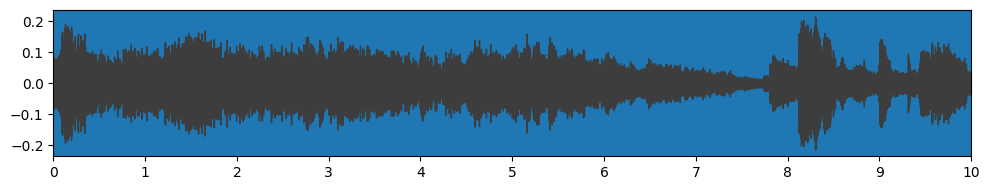

Aspect List: ['guitar song', 'piano backing', 'simple percussion', 'relaxing melody', 'slow tempo', 'bass', 'country feel', 'instrumental', 'no voice']
Caption: This song features an electric guitar as the main instrument. The guitar plays a descending run in the beginning then plays an arpeggiated chord followed by a double stop hammer on to a higher note and a descending slide followed by a descending chord run. The percussion plays a simple beat using rim shots. The percussion plays in common time. The bass plays only one note on the first count of each bar. The piano plays backing chords. There are no voices in this song. The mood of this song is relaxing. This song can be played in a coffee shop.


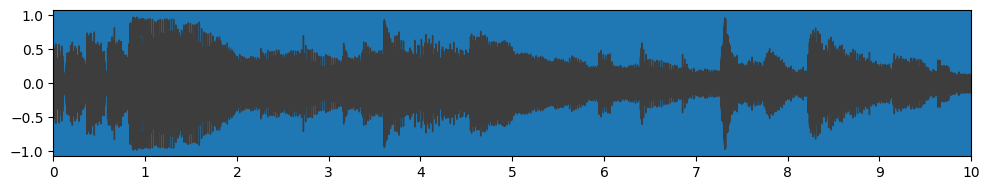

Aspect List: ['amateur recording', 'finger snipping', 'male mid range voice singing', 'reverb']
Caption: a male voice is singing a melody with changing tempos while snipping his fingers rhythmically. The recording sounds like it has been recorded in an empty room. This song may be playing, practicing snipping and singing along.


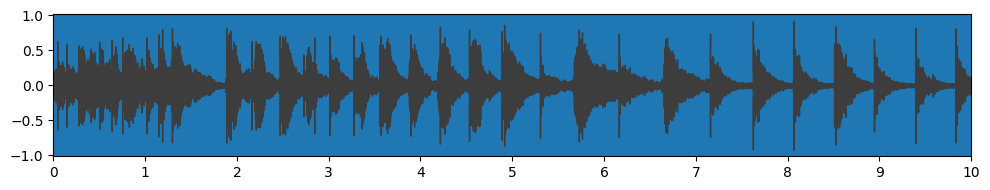

In [11]:
waveforms = WaveformExtractor(downloaded_dataset, audio_column="audio", time_fixed=10)

for i in range(3):
    print(f"Aspect List: {downloaded_dataset[i]['aspect_list']}")
    print(f"Caption: {downloaded_dataset[i]['caption']}")
    waveform = waveforms[i].cpu().numpy()
    AudioViewer.get_waveform(np.array([waveform]), sample_rate=sampling_rates[i])

 * Spectrogram

Aspect List: ['low quality', 'sustained strings melody', 'soft female vocal', 'mellow piano melody', 'sad', 'soulful', 'ballad']
Caption: The low quality recording features a ballad song that contains sustained strings, mellow piano melody and soft female vocal singing over it. It sounds sad and soulful, like something you would hear at Sunday services.


d:\Documents\Workspaces\Python\text-to-music\.venv\Lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


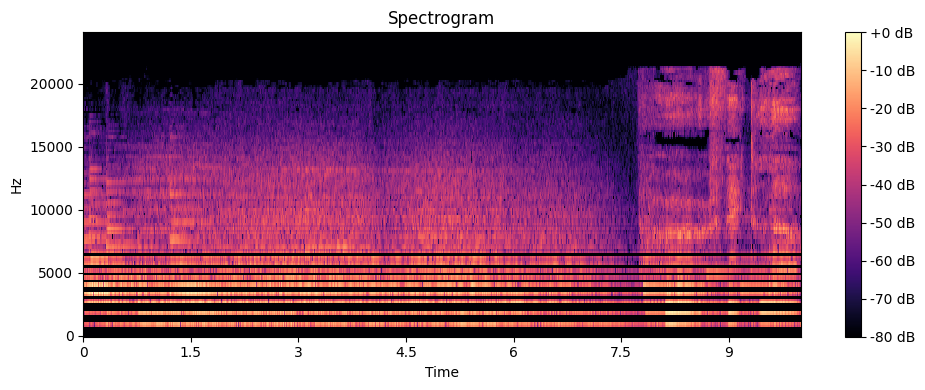

Aspect List: ['guitar song', 'piano backing', 'simple percussion', 'relaxing melody', 'slow tempo', 'bass', 'country feel', 'instrumental', 'no voice']
Caption: This song features an electric guitar as the main instrument. The guitar plays a descending run in the beginning then plays an arpeggiated chord followed by a double stop hammer on to a higher note and a descending slide followed by a descending chord run. The percussion plays a simple beat using rim shots. The percussion plays in common time. The bass plays only one note on the first count of each bar. The piano plays backing chords. There are no voices in this song. The mood of this song is relaxing. This song can be played in a coffee shop.


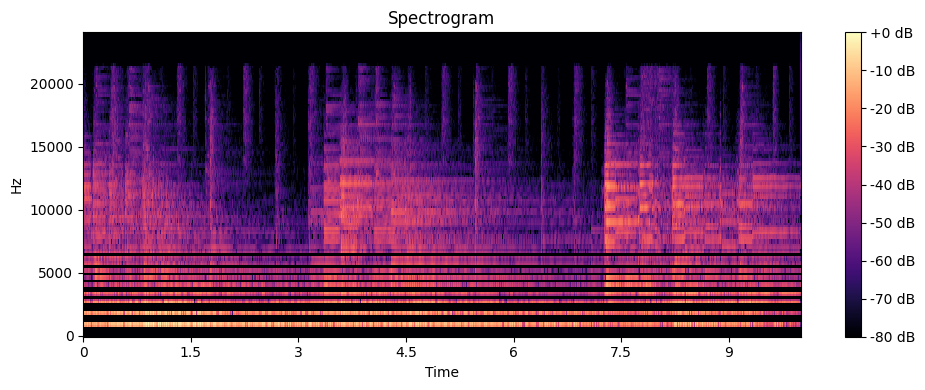

Aspect List: ['amateur recording', 'finger snipping', 'male mid range voice singing', 'reverb']
Caption: a male voice is singing a melody with changing tempos while snipping his fingers rhythmically. The recording sounds like it has been recorded in an empty room. This song may be playing, practicing snipping and singing along.


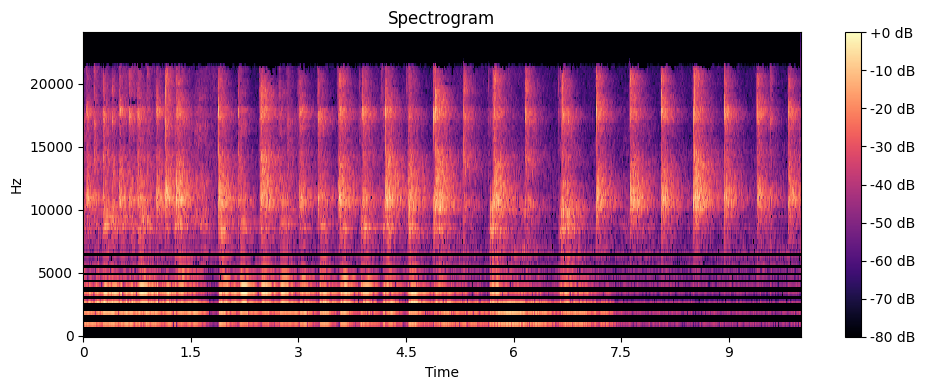

In [12]:
spectrograms = SpectrogramExtractor(downloaded_dataset, audio_column="audio")

for i in range(3):
    print(f"Aspect List: {downloaded_dataset[i]['aspect_list']}")
    print(f"Caption: {downloaded_dataset[i]['caption']}")
    spectrogram = spectrograms[i].cpu().numpy()
    AudioViewer.get_spectrogram(spectrogram, sample_rate=sampling_rates[i])
